In [1]:
#@title 默认标题文本
!pip install gym-retro
import torch
import torch.nn as nn
import torchvision.models as models
import retro
import numpy as np
import matplotlib.pyplot as plt
import joblib
import copy

     |████████████████████████████████| 162.0 MB 24 kB/s 


In [2]:
env = retro.make(game='Airstriker-Genesis')

In [3]:
class Actor_NN(nn.Module):
    def __init__(self):
        super(Actor_NN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(8, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        # self.cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval().requires_grad_(requires_grad=False)
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
        self.fc = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128, affine=True),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32, affine=True),
            nn.ReLU(),
            nn.Linear(32, 6),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x2 = x.permute(0, 3, 2, 1)
        y = self.cnn(x2)
        y1 = self.pool(y)
        y1 = torch.flatten(y1, start_dim=1, end_dim=-1)
        z = self.fc(y1)
        return z


class Critic_NN(nn.Module):
    def __init__(self):
        super(Critic_NN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(8, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        # self.cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval().requires_grad_(requires_grad=False)
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
        self.fc = nn.Sequential(
            nn.Linear(784, 64),
            nn.BatchNorm1d(64, affine=True),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16, affine=True),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        x2 = x.permute(0, 3, 2, 1)
        y = self.cnn(x2)
        y1 = self.pool(y)
        y1 = torch.flatten(y1, start_dim=1, end_dim=-1)
        z = self.fc(y1)
        return z


In [4]:
class PPO(nn.Module):
    def __init__(self, timestep, discount, batch, device, lr, lamb, actor_update, critic_update):
        super(PPO, self).__init__()
        self.actor_update = actor_update
        self.critic_update = critic_update
        self.lamb = lamb  
        self.lr = lr
        self.device = device
        self.batch_size = batch
        self.timestep = timestep
        self.gamma = discount
        self.ji = self.lamb * self.gamma
        self.coeff = torch.tensor([self.ji**i for i in range(timestep)]).to(self.device)  # 算advantage
        self.target_coeff = torch.tensor([self.gamma**i for i in range(timestep)]).to(device) # 算target，折扣因子
        self.epsilon = 0.2
        self.actor = Actor_NN().to(self.device)
        self.old_actor = Actor_NN().to(self.device)
        self.critic = Critic_NN().to(self.device)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.lr)
        self.discrete_action = []
        self.decode_action()

    def decode_action(self):
        buttons = env.unwrapped.buttons
        combos = [[],['B'],['LEFT'],['RIGHT'],['B','LEFT'],['B','RIGHT']]
        for combo in combos:
            # arr = np.array([0] * env.action_space.n)
            arr = [0,0,0,0,0,0,0,0,0,0,0,0]
            for button in combo:
                arr[buttons.index(button)] = 1
            self.discrete_action.append(arr)
        # self.discrete_action = np.array(self.discrete_action)

    def action_select(self, s):
        s = (torch.FloatTensor(s)).to(self.device)
        prob = self.actor(s)
        dist = torch.distributions.Categorical(prob.squeeze(0))
        action = self.discrete_action[dist.sample()]
        return action


    def actor_learn(self, s, a, advantage):

        prob = self.actor(s[:self.batch_size])
        pi = torch.distributions.Categorical(prob)

        old_prob = self.old_actor(s[:self.batch_size])
        old_pi = torch.distributions.Categorical(old_prob)
        # print(self.discrete_action)
        # print(a)
        a = torch.tensor([self.discrete_action.index(list(i.cpu())) for i in a]).to(self.device)
        # print(a)
        # print(pi.log_prob(a))
        # print(old_pi.log_prob(a))
        ratio = torch.exp(pi.log_prob(a) - old_pi.log_prob(a))

        advantage = torch.tensor(advantage).to(self.device)
        surr = (ratio * advantage).reshape(-1,1)  # torch.Size([batch, 1])

        # mean取均值，就是期望
        # 这个loss就是画面价值，越高越好
        loss = -torch.mean(
            torch.min(surr, torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage.reshape(-1, 1)))

        self.actor_optim.zero_grad()
        loss.backward()
        self.actor_optim.step()

    def critic_learn(self, targets, s): # 传入s重新计算V而不用self.V一个是因为actor反向传播后会清空梯度，
                      # 在这里就无法反向传播了，再一个就是多次反向传播每次都会清空梯度
        
        self.V = self.critic(s).reshape(self.batch_size+self.timestep)
        targets_ = torch.FloatTensor(targets).to(self.device)

        loss_func = nn.MSELoss()
        # print(targets_.shape)
        # print(self.V[:self.batch_size].shape)
        loss = loss_func(self.V[:self.batch_size], targets_)

        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()

    def target_cal(self, r):  # 用于更新critic
        targets = []
        for i in range(self.batch_size):
          # print(r[i].device)
          # print(self.V.device)
          # print(self.target_coeff.device)
          target = r[i] + torch.sum(self.V[i+1:i+self.timestep+1,0]*self.target_coeff)
          targets.append(int(target))
        
        return targets

    def delta_cal(self, r, s):  

        self.V = self.critic(s)
        delta = []
        for i in range(len(self.V)-1):
            delta0 = r[i] + self.gamma * self.V[i+1,0] - self.V[i,0]
            delta.append(int(delta0))

        return delta  # 用来计算advantage

    def adv_cal(self, delta):

        advantage = []
        delta_ = torch.tensor(delta).to(self.device)
        for i in range(self.batch_size):
          adv = torch.sum(self.coeff * delta_[i:i+self.timestep])
          advantage.append(int(adv))

        return advantage

    def update(self, s, a, delta, targets):
        self.old_actor.load_state_dict(self.actor.state_dict())
        advantage = self.adv_cal(delta)

        for i in range(self.actor_update):
            self.actor_learn(s, a, advantage)

        for i in range(self.critic_update):
            self.critic_learn(targets, s)

In [5]:
DEVICE = torch.device('cuda')
BATCH = 64
EPSILON = 0.98
DISCOUNT = 0.99
TIME_STEP = 256
GAE_PARA = 0.95
CLIPING = 0.1
N_EPISODE = 721
LR = 2.5*1e-4
Actor_Update = 3
Critic_Update = 3

In [6]:
env.seed(23)
torch.manual_seed(23)

agent = PPO(TIME_STEP, DISCOUNT, BATCH, DEVICE, LR, 
            GAE_PARA, Actor_Update, Critic_Update).to(DEVICE)

In [7]:
agent.load_state_dict(torch.load("/content/ppo_480.pth"))

<All keys matched successfully>

In [8]:

kmeans_died = joblib.load("/content/k_means_died")
# kmeans_left = joblib.load("/content/k_means_left")
# kmeans_right = joblib.load("/content/k_means_right")

all_ep_r = []
for i in range(N_EPISODE):
    ep_r = 0
    s = env.reset()[24:, :, :]
    # env.render()
    states, actions, rewards = [], [], []
    done = False
    t = 0
    life_index = 0
    life = np.empty(2)
    while done is False:
        a = agent.eval().action_select(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        s_, r, done, _ = env.step(a)
        # 存储前后两帧的生死信息
        if_died = kmeans_died.predict([s_[128:135, 120:207, :].flatten()])
        # print(if_died)
        # 0是活着，1是死了
        index = life_index % 2
        life[index] = if_died
        life_index += 1

        # # 检测是否在左右两个角落，修改奖励来避免一直躲在角落
        # right = kmeans_right.predict([s_[180:220, 260:310, :].flatten()])
        # left = kmeans_left.predict([s_[180:220, 5:55, :].flatten()])
        # # 0是最边上的角落里，1是不在那个小角落

        s_ = s_[24:, :, :]

        # 修改奖励(每帧存活就有奖励+2，死亡一条命-500，躲在角落里每帧-1)
        if r > 0:
            r = 80  # 打掉飞机奖励改为80
        elif life[0] == 0 and life[1] == 0:
            r = 1
        elif life[(index + 1) % 2] == 0 and life[index] == 1:  # 检测两帧的，防止死亡画面过长一直减分数
            r = -500
        # if not (right and left):
        #     r -= 2

        ep_r += r
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = s_

        t += 1  # 加完之后t为存储的个数

        if t % (BATCH + TIME_STEP) == 0:  # 括号里不减一是因为算delta还要算下一时刻的V
            
            states = torch.FloatTensor(np.array(states)).to(DEVICE)   # list里是ndarray的s，先全换成ndarray，再换成tensor，快很多很多
            actions = torch.tensor(actions[:agent.batch_size]).to(DEVICE)
            rewards = torch.tensor(rewards).to(DEVICE)
            
            delta = agent.delta_cal(rewards, states)
            targets = agent.target_cal(rewards)
            
            # 计算delta，截断版本的advantage
            agent.train().update(states, actions, delta, targets)  # 进行actor和critic网络的更新
            states, actions, rewards = [], [], []

    print('Episode {:03d} | Reward:{:.03f}'.format(i, ep_r))
    if i % 40 == 0:
        torch.save(agent.state_dict(),"/content/ppo_"+str(i)+".pth")
    if i == 481:
        all_ep_r.append(ep_r)
    else:
        all_ep_r.append(all_ep_r[-1] * 0.9 + ep_r * 0.1)  # 平滑

plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.show()

Episode 481 | Reward:275.000
Episode 482 | Reward:206.000
Episode 483 | Reward:462.000
Episode 484 | Reward:1345.000
Episode 485 | Reward:30.000
Episode 486 | Reward:-395.000
Episode 487 | Reward:-460.000
Episode 488 | Reward:-332.000
Episode 489 | Reward:-219.000
Episode 490 | Reward:15.000
Episode 491 | Reward:-29.000
Episode 492 | Reward:-105.000
Episode 493 | Reward:-336.000
Episode 494 | Reward:414.000
Episode 495 | Reward:619.000
Episode 496 | Reward:-518.000
Episode 497 | Reward:20.000
Episode 498 | Reward:-76.000
Episode 499 | Reward:686.000
Episode 500 | Reward:-634.000
Episode 501 | Reward:-126.000
Episode 502 | Reward:113.000
Episode 503 | Reward:-258.000
Episode 504 | Reward:-24.000
Episode 505 | Reward:-149.000
Episode 506 | Reward:924.000
Episode 507 | Reward:550.000
Episode 508 | Reward:676.000
Episode 509 | Reward:10.000
Episode 510 | Reward:20.000
Episode 511 | Reward:214.000
Episode 512 | Reward:553.000
Episode 513 | Reward:-110.000
Episode 514 | Reward:-324.000
Episo

KeyboardInterrupt: ignored

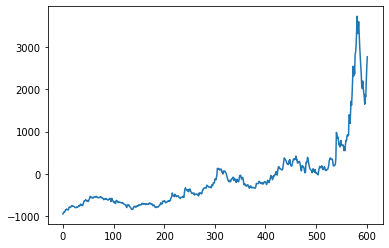

In [30]:
plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.show()